## Reserve and configure resources on KVM

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

### Configure environment

In [2]:
import openstack, chi, chi.ssh, chi.network, chi.server, os

In this section, we configure the Chameleon Python client.

For this experiment, we’re going to use the KVM@TACC site, which we indicate below.

We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your own project ID, then run the cell.

In [3]:
chi.use_site("KVM@TACC")
PROJECT_NAME = "CHI-231138"
chi.set("project_name", PROJECT_NAME)

# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()


Now using KVM@TACC:
URL: https://kvm.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need four virtual machines connected to a common network. Each of the virtual machines will be of the `m1.medium` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

* Node-0 will be used to run the MLFlow tracking server
* Node-1 will be used to deploy the postgres database to to server as the parameter store 
* Node-2 will be used as the model registry using MiniIO as the artifact store.

In [5]:
username = os.getenv('USER')

node_conf = [
 {'name': "node-0",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv"], 'bastion': True}, 
 {'name': "node-1",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv", "docker-compose"], 'bastion': False},
 {'name': "node-2",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv", "docker-compose"], 'bastion': False}
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}]},
]
route_conf = []

### Configure resources

Now, we will prepare the VMs and network links that our experiment requires.

First, we will prepare a “public” network that we will use for SSH access to our VMs -

In [6]:
public_net = os_conn.network.create_network(name="public_net_" + username)
public_net_id = public_net.get("id")
public_subnet = os_conn.network.create_subnet(
    name="public_subnet_" + username,
    network_id=public_net.get("id"),
    ip_version='4',
    cidr="192.168.10.0/24",
    gateway_ip="192.168.10.1",
    is_dhcp_enabled = True
)

Next, we will prepare the “experiment” networks -

In [7]:
nets = []
net_ids = []
subnets = []
for n in net_conf:
    exp_net = os_conn.network.create_network(name="exp_" + n['name']  + '_' + username)
    exp_net_id = exp_net.get("id")
    os_conn.network.update_network(exp_net, is_port_security_enabled=False)
    exp_subnet = os_conn.network.create_subnet(
        name="exp_subnet_" + n['name']  + '_' + username,
        network_id=exp_net.get("id"),
        ip_version='4',
        cidr=n['subnet'],
        gateway_ip=None,
        is_dhcp_enabled = True
    )
    nets.append(exp_net)
    net_ids.append(exp_net_id)
    subnets.append(exp_subnet)

Now we create the VMs -

In [8]:
servers = []
server_ids = []
for i, n in enumerate(node_conf, start=10):
    image_uuid = os_conn.image.find_image(n['image']).id
    flavor_uuid = os_conn.compute.find_flavor(n['flavor']).id
    # find out details of exp interface(s)
    nics = [{'net-id': chi.network.get_network_id( "exp_" + net['name']  + '_' + username ), 'v4-fixed-ip': node['addr']} for net in net_conf for node in net['nodes'] if node['name']==n['name']]
    # also include a public network interface
    nics.insert(0, {"net-id": public_net_id, "v4-fixed-ip":"192.168.10." + str(i)})
    server = chi.server.create_server(
        server_name=n['name'] + "_" + username,
        image_id=image_uuid,
        flavor_id=flavor_uuid,
        nics=nics
    )
    servers.append(server)
    server_ids.append(chi.server.get_server(n['name'] + "_" + username).id)

We wait for all servers to come up before we proceed -

In [9]:
for server_id in server_ids:
    chi.server.wait_for_active(server_id)

Next, we will set up SSH access to the VMs.

First, we will make sure the “public” network is connected to the Internet. Then, we will configure it to permit SSH access on port 22 for each port connected to this network.

In [10]:
# connect them to the Internet on the "public" network (e.g. for software installation)
router = chi.network.create_router('inet_router_' + username, gw_network_name='public')
chi.network.add_subnet_to_router(router.get("id"), public_subnet.get("id"))

{'network_id': '77a12e69-c5a7-4e20-a311-c39282c7696a',
 'tenant_id': '13a1ac1ce275484caedc3394339486a1',
 'subnet_id': '9eb5dd37-daa4-46cf-a771-c316589b0880',
 'subnet_ids': ['9eb5dd37-daa4-46cf-a771-c316589b0880'],
 'port_id': '95cf6211-480b-4b06-8a19-1b7a12a1060d',
 'id': '33a42c9e-77c5-460a-9626-dee0e193a2bd'}

In [11]:
# prepare SSH access on the servers that serve in "bastion" role
# WARNING: this relies on undocumented behavior of associate_floating_ip 
# that it associates the IP with the first port on the server
server_ips = ["129.114.27.11"]
# for i, n in enumerate(node_conf):
#     if 'bastion' in n and n['bastion']:
#         ip = chi.server.associate_floating_ip(server_ids[i])
#         server_ips.append(ip)

In [12]:
if not os_conn.get_security_group("Allow SSH"):
    os_conn.create_security_group("Allow SSH", "Enable SSH traffic on TCP port 22")
    os_conn.create_security_group_rule("Allow SSH", port_range_min=22, port_range_max=22, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

security_group_id = os_conn.get_security_group("Allow SSH").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        os_conn.network.update_port(port['id'], security_groups=[security_group_id])

In [13]:
for ip in server_ips:
    chi.server.wait_for_tcp(ip, port=22)

The following cell may raise an error if some of your nodes are still getting set up! If that happens, wait a few minutes and try again. (And then a few minutes more, and try again, if it still raises an error.)

In [14]:
primary_remote = chi.ssh.Remote(server_ips[0])
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
server_remotes = [chi.ssh.Remote(physical_ip, gateway=primary_remote) for physical_ip in physical_ips]

Finally, we need to configure our resources, including software package installation and network configuration.

In [15]:
import time
for i, n in enumerate(node_conf):
    remote = server_remotes[i]
    # enable forwarding
    remote.run(f"sudo sysctl -w net.ipv4.ip_forward=1") 
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=192.168.0.0/16 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=172.16.0.0/12 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=10.0.0.0/8 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=127.0.0.0/8 --permanent")
    # these are required for etcd
    remote.run(f"sudo firewall-cmd --zone=public --add-port=4001/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=2379-2380/tcp")
    time.sleep(3)

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.27.11: b'82365d3d13f7c495e3d6095d6efafa70'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'82365d3d13f7c495e3d6095d6efafa70'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'93d0ba6775ebfd2e297afbec4eff4dc4'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'7ea885a6a498acf9d45567e933f5973c'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


In [16]:
for i, n in enumerate(node_conf):
    # install packages
    if len(n['packages']):
            remote = server_remotes[i]
            remote.run(f"sudo apt update; sudo apt -y install " + " ".join(n['packages'])) 

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2040 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [13.3 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2772 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [580 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [959 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [19.5 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [37.6 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [224 B]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:12 http://nova.clouds.archive

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl
Suggested packages:
  python2-pip-whl python2-setuptools-whl
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl virtualenv
0 upgraded, 8 newly installed, 0 to remove and 51 not upgraded.
Need to get 1750 kB of archives.
After this operation, 9000 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-distlib all 0.3.4-1 [269 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-filelock all 3.6.0-1 [8788 B]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 1750 kB in 1s (3041 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 84249 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../2-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../3-python3-pip_22.0.2+dfsg-1ubuntu0.5_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.5) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../4-python3-platformdirs_2.5.1-1_all.deb ...
Unpacking python3-platformdirs (2.5.1-1) ...
Selecting previously unselected packa

Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2040 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [13.3 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2772 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [580 B]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [959 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [19.5 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [37.6 kB]
Get:12 http://security.ubuntu.com/ubuntu j

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-distlib python3-docker python3-dockerpty python3-docopt
  python3-dotenv python3-filelock python3-pip python3-platformdirs
  python3-texttable python3-virtualenv python3-websocket python3-wheel
  python3-wheel-whl
Suggested packages:
  python2-pip-whl python2-setuptools-whl
Recommended packages:
  docker.io
The following NEW packages will be installed:
  docker-compose python3-distlib python3-docker python3-dockerpty
  python3-docopt python3-dotenv python3-filelock python3-pip
  python3-platformdirs python3-texttable python3-virtualenv python3-websocket
  python3-wheel python3-wheel-whl virtualenv
0 upgraded, 15 newly installed, 0 to remove and 51 not upgraded.
Need to get 2040 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-web

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 2040 kB in 2s (1308 kB/s)
Selecting previously unselected package python3-websocket.
(Reading database ... 84249 files and directories currently installed.)
Preparing to unpack .../00-python3-websocket_1.2.3-1_all.deb ...
Unpacking python3-websocket (1.2.3-1) ...
Selecting previously unselected package python3-docker.
Preparing to unpack .../01-python3-docker_5.0.3-1_all.deb ...
Unpacking python3-docker (5.0.3-1) ...
Selecting previously unselected package python3-dockerpty.
Preparing to unpack .../02-python3-dockerpty_0.4.1-2_all.deb ...
Unpacking python3-dockerpty (0.4.1-2) ...
Selecting previously unselected package python3-docopt.
Preparing to unpack .../03-python3-docopt_0.6.2-4_all.deb ...
Unpacking python3-docopt (0.6.2-4) ...
Selecting previously unselected package python3-dotenv.
Preparing to unpack .../04-python3-dotenv_0.19.2-1_all.deb ...
Unpacking python3-dotenv (0.19.2-1) ...
Selecting previously unselected package python3-texttable.
Preparing to unpack .../05-pyt

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2040 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [13.3 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2772 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [580 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [959 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [19.5 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [37.6 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [224 B]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:12 http://nova.clouds.archive

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-distlib python3-docker python3-dockerpty python3-docopt
  python3-dotenv python3-filelock python3-pip python3-platformdirs
  python3-texttable python3-virtualenv python3-websocket python3-wheel
  python3-wheel-whl
Suggested packages:
  python2-pip-whl python2-setuptools-whl
Recommended packages:
  docker.io
The following NEW packages will be installed:
  docker-compose python3-distlib python3-docker python3-dockerpty
  python3-docopt python3-dotenv python3-filelock python3-pip
  python3-platformdirs python3-texttable python3-virtualenv python3-websocket
  python3-wheel python3-wheel-whl virtualenv
0 upgraded, 15 newly installed, 0 to remove and 51 not upgraded.
Need to get 2040 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-web

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 2040 kB in 1s (1576 kB/s)
Selecting previously unselected package python3-websocket.
(Reading database ... 84249 files and directories currently installed.)
Preparing to unpack .../00-python3-websocket_1.2.3-1_all.deb ...
Unpacking python3-websocket (1.2.3-1) ...
Selecting previously unselected package python3-docker.
Preparing to unpack .../01-python3-docker_5.0.3-1_all.deb ...
Unpacking python3-docker (5.0.3-1) ...
Selecting previously unselected package python3-dockerpty.
Preparing to unpack .../02-python3-dockerpty_0.4.1-2_all.deb ...
Unpacking python3-dockerpty (0.4.1-2) ...
Selecting previously unselected package python3-docopt.
Preparing to unpack .../03-python3-docopt_0.6.2-4_all.deb ...
Unpacking python3-docopt (0.6.2-4) ...
Selecting previously unselected package python3-dotenv.
Preparing to unpack .../04-python3-dotenv_0.19.2-1_all.deb ...
Unpacking python3-dotenv (0.19.2-1) ...
Selecting previously unselected package python3-texttable.
Preparing to unpack .../05-pyt

In [22]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for remote in server_remotes:
    for h in hosts_txt:
        remote.run("echo %s | sudo tee -a /etc/hosts > /dev/null" % h)

## TA Notes: (To be removed)

 No permissions to remove the existing security group - the next cell fails

In [26]:
# we also need to enable incoming traffic on the HTTP port
if not os_conn.get_security_group("Allow HTTP 8000"):
    os_conn.create_security_group("Allow HTTP 8000", "Enable HTTP traffic on TCP port 8000")
    os_conn.create_security_group_rule("Allow HTTP 8000", port_range_min=8000, port_range_max=8000, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

# add existing security group
security_group_id = os_conn.get_security_group("Allow HTTP 8000").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        pri_security_groups = port['security_groups']
        pri_security_groups.append(security_group_id)
        os_conn.network.update_port(port['id'], security_groups=pri_security_groups)

BadRequestException: BadRequestException: 400: Client Error for url: https://kvm.tacc.chameleoncloud.org:9696/v2.0/ports/25c0b592-8e77-4572-a115-1771aa00d5a7, Invalid input for security_groups. Reason: Duplicate items in the list: '8881b2ef-5558-4770-b4d8-5893e86486c0'.

### Draw the network topology

The following cells will draw the network topology, for your reference.

In [27]:
!pip install networkx

In [28]:
nodes = [ (n['name'], {'color': 'pink'}) for n in net_conf ] + [(n['name'], {'color': 'lightblue'}) for n in node_conf ]
edges = [(net['name'], node['name'], 
          {'label': node['addr'] + '/' + net['subnet'].split("/")[1] }) if node['addr'] else (net['name'], node['name']) for net in net_conf for node in net['nodes'] ]

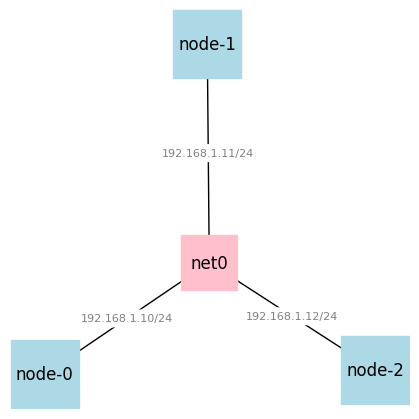

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Get SSH login details

At this point, we should be able to log in to our “controller” node over SSH! Run the following cell, and observe the output - you will see an SSH command this node.

In [30]:
print("ssh cc@" + server_ips[0])

ssh cc@129.114.27.11


Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.

Alternatively, you can use your local terminal to log on to each node, if you prefer. (On your local terminal, you may need to also specify your key path as part of the SSH command, using the `-i` argument followed by the path to your private key.)

### Install packages on the tracking server (Node 0)


We now install the packages required for for the mlflow tracking server to run on the bastion node.

In [31]:
remote = chi.ssh.Remote(server_ips[0])

In [32]:
remote.run("pip install scikit-learn;")
remote.run("pip install mlflow psycopg2-binary boto3")

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.27.11: b'82365d3d13f7c495e3d6095d6efafa70'
  warnings.warn(


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 21.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

<Result cmd='pip install mlflow psycopg2-binary boto3' exited=0>